In [253]:
from commonfunctions import  *

## Reading dataset

In [254]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

datagen1 = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.6,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.5, 0.9]
)
def readingAndConvert(img_path: str) -> np.ndarray:
    image = io.imread(img_path).astype(np.uint8)
    if len(image.shape) == 2:   
        return np.expand_dims(image, axis=-1) 
        #return image
    else:
        gray_img = rgb2gray(image)
        return gray_img
        #return gray_img

def readDataset(dir: str) -> list[np.ndarray]:
    dataset = []
    read_imgs = os.listdir(dir)
    for i in range(len(read_imgs)):
        dataset.append(readingAndConvert(dir + read_imgs[i]))
        img = readingAndConvert(dir + read_imgs[i])
        img = np.expand_dims(img, axis=0)  
        augmented_imgs = datagen.flow(img, batch_size=1)
        augmented_img = augmented_imgs[0][0]
        dataset.append(augmented_img)

        img1 = readingAndConvert(dir+ read_imgs[i])
        img1= np.expand_dims(img1, axis=0)  
        augmented_imgs1 = datagen1.flow(img1, batch_size=1)
        augmented_img1 = augmented_imgs1[0][0]
        dataset.append(augmented_img1)
    return dataset

def readingAndConvertTest(img_path: str) -> np.ndarray:
    image = io.imread(img_path).astype(np.uint8)
    if len(image.shape) == 2:   
        return np.expand_dims(image, axis=-1) 
        #return image
    else:
        gray_img = rgb2gray(image)
        return np.expand_dims(gray_img, axis=-1) 
        #return gray_img
    
forged_imgs = readDataset('forged/')
real_imgs = readDataset('real/')
test_img = readingAndConvertTest('testImgs/emdaSohad.jpeg')
show_images([test_img])

test_imgs=[test_img]


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 1599, 899))

## noise removal

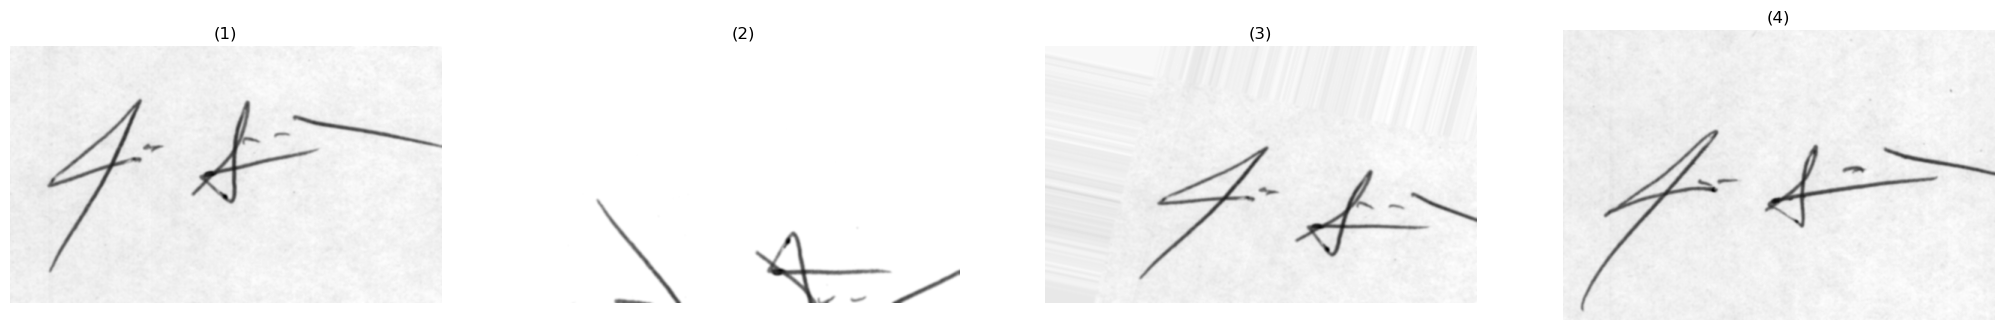

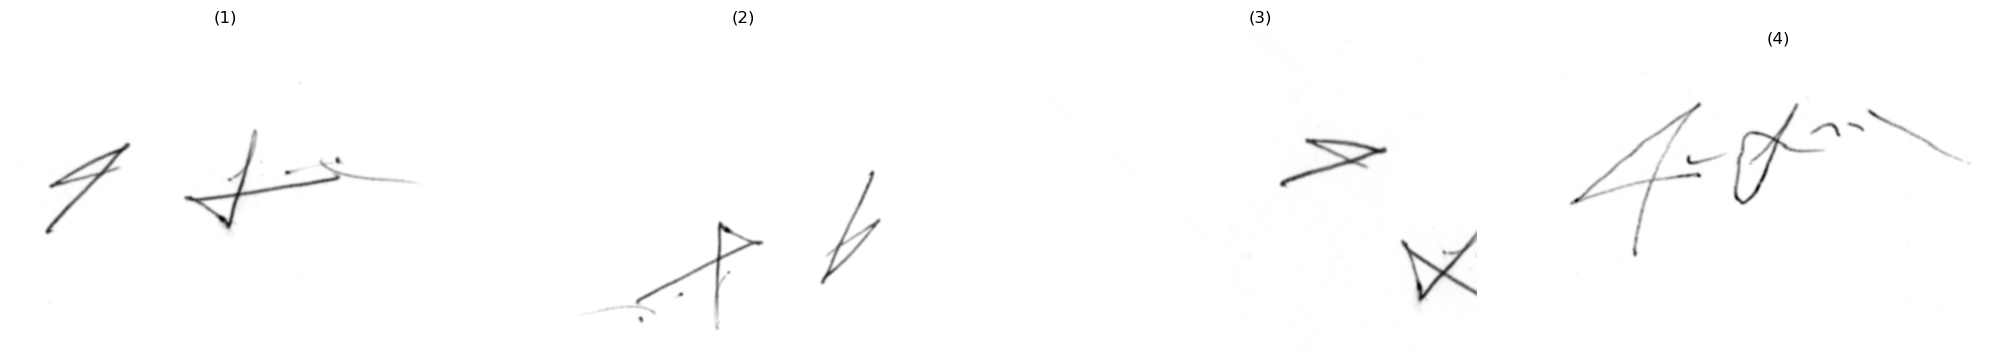

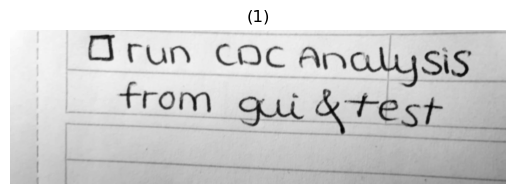

In [ ]:
# removing noise using gaussian, we will try median filter on other test images

# apply median filter

# def median_filter(img,w,h):
#     edgex = math.floor(w/2)
#     edgey= math.floor(h/2)
#     img2=img.copy()
#     for x in range(edgex ,  img.shape[1] - edgex):
#         for y in range(edgey, img.shape[0] - edgey):
#             colorArray =np.zeros([w,h])
#             for fx in range(w):
#                 for fy in range(h):
#                     colorArray[fy][fx] = img[y + fy - edgey] [x + fx - edgex] 


def noiseRemoval(img: np.ndarray) -> np.ndarray:
    clean_img = gaussian(img, 1.2)
    return clean_img

def noiseRemovalOnDataSet(imgs: list[np.ndarray]) -> None:
    for i in range(len(imgs)):
        imgs[i] = noiseRemoval(imgs[i])

noiseRemovalOnDataSet(real_imgs)
noiseRemovalOnDataSet(forged_imgs)
noiseRemovalOnDataSet(test_imgs)
show_images(real_imgs[:4])
show_images(forged_imgs[:4])
show_images(test_imgs)


## contrast enhancement

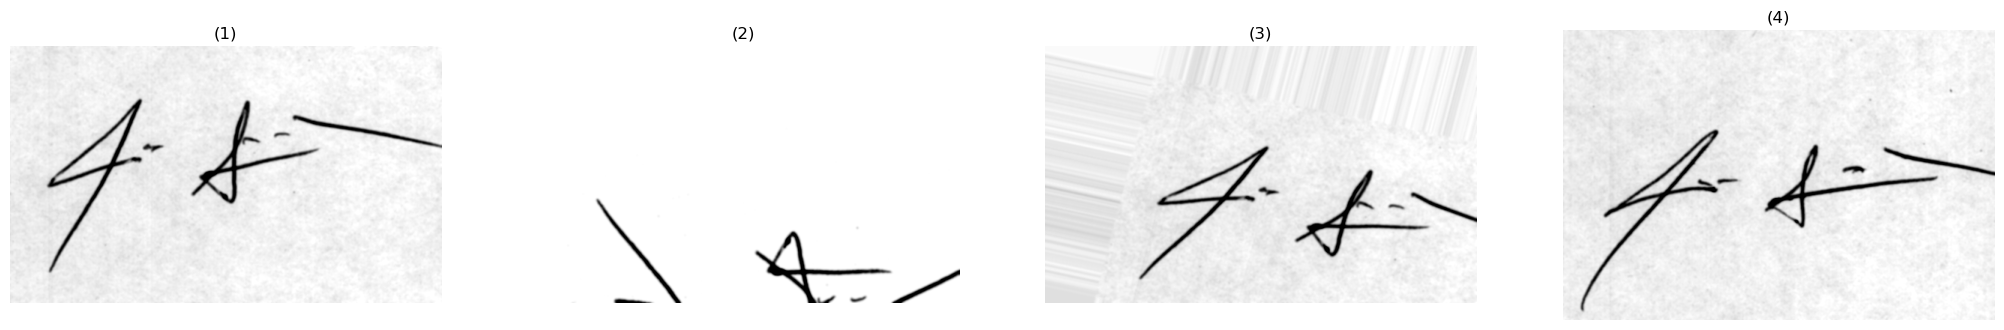

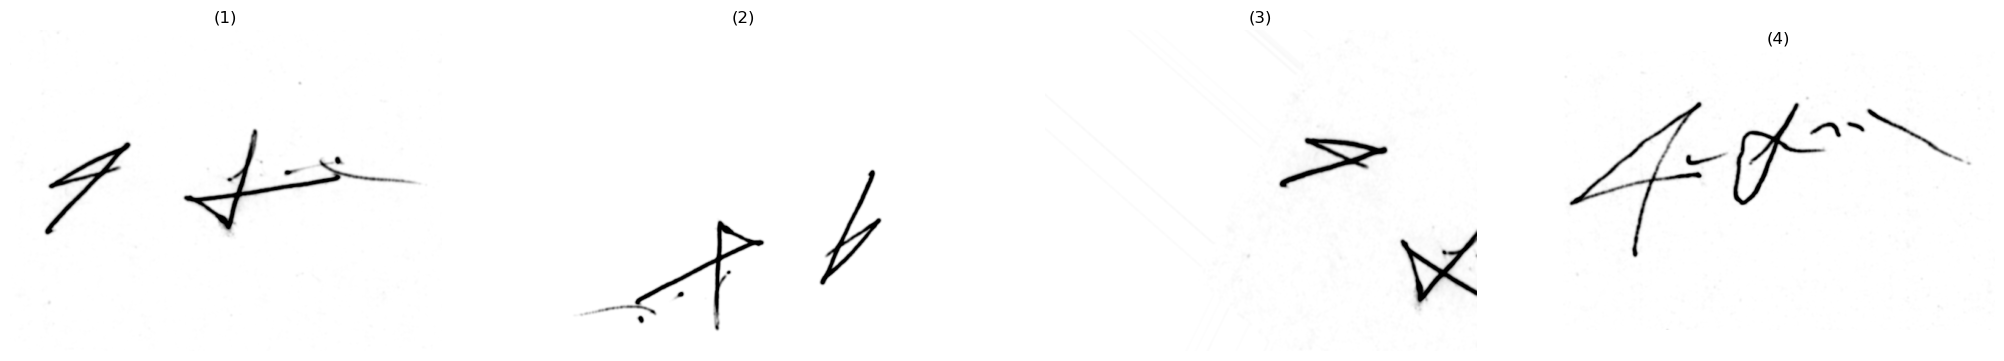

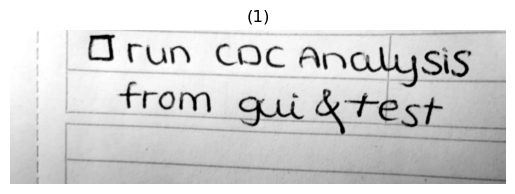

In [ ]:
def contrastEnhancemet(imgs: list[np.ndarray]) -> None:
    for i in range(len(imgs)):
        low, high = np.percentile(imgs[i], [1, 99])
        imgs[i] = rescale_intensity(imgs[i], in_range=(low, high))

contrastEnhancemet(real_imgs)
contrastEnhancemet(forged_imgs)
contrastEnhancemet(test_imgs)

show_images(real_imgs[:4])
show_images(forged_imgs[:4])
show_images(test_imgs)

## binarization

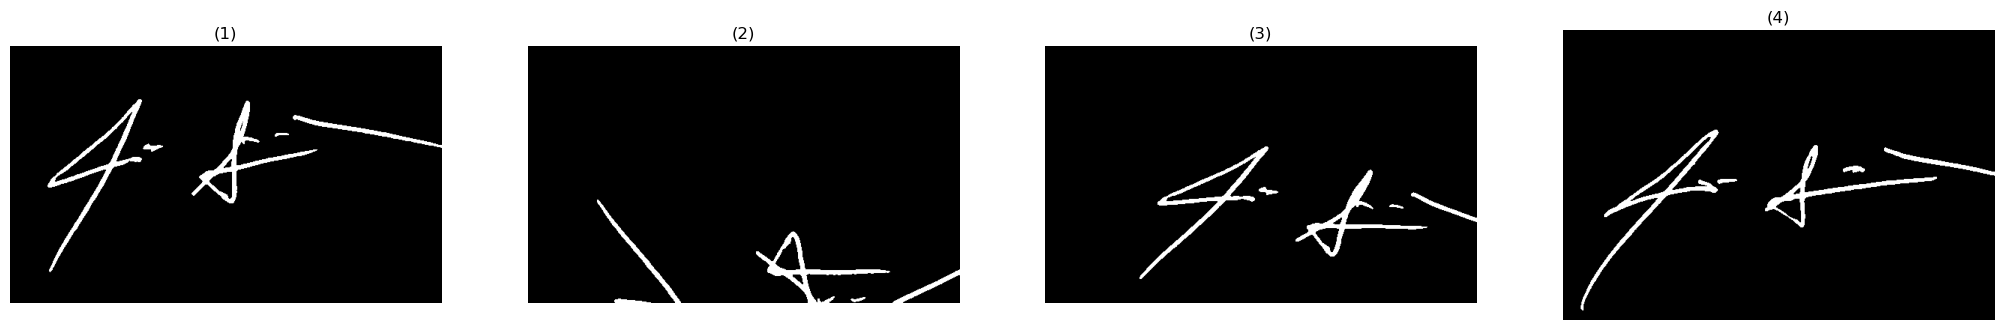

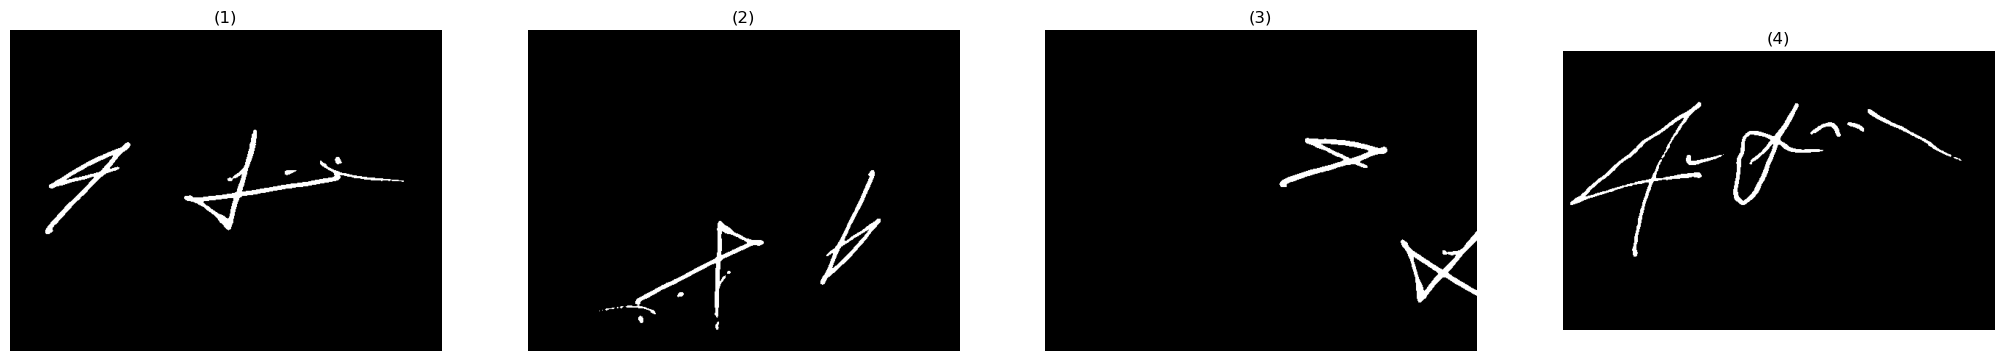

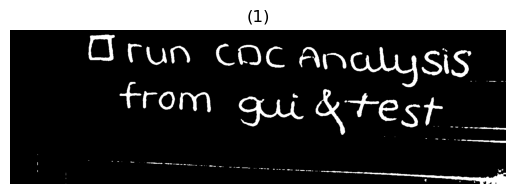

In [ ]:
def binarize(imgs: list[np.ndarray]) -> None:
    binarized_imgs=[]
    for i in range(len(imgs)):
        threshold = threshold_otsu(imgs[i])
        binarized_imgs.append(imgs[i] < threshold)
        binarized_imgs[i] = binarized_imgs[i].astype(np.uint8)
    return binarized_imgs

real_imgs_binarized = binarize(real_imgs)
forged_imgs_binarized = binarize(forged_imgs)
test_imgs_binarized = binarize(test_imgs)

show_images(real_imgs_binarized[:4])
show_images(forged_imgs_binarized[:4])
show_images(test_imgs_binarized)


## skew correction

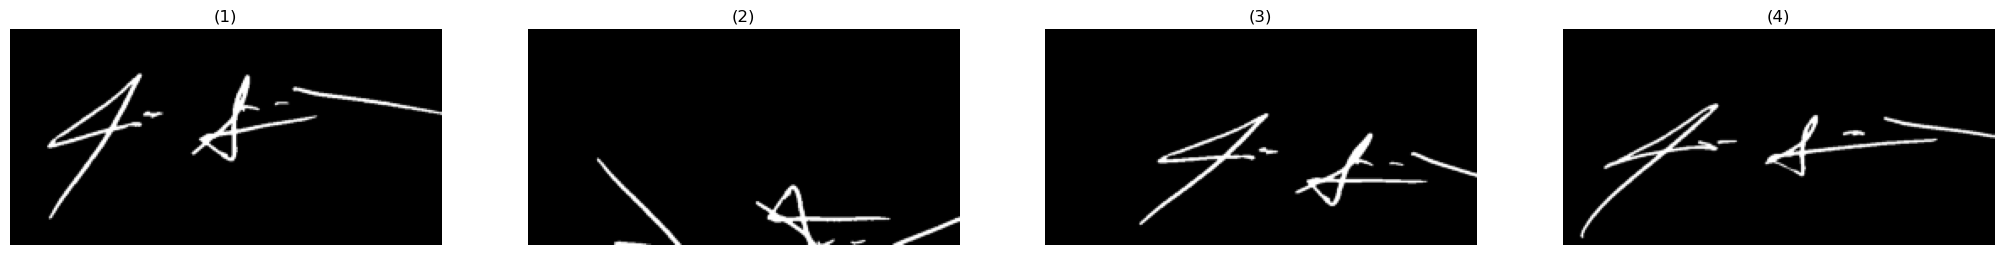

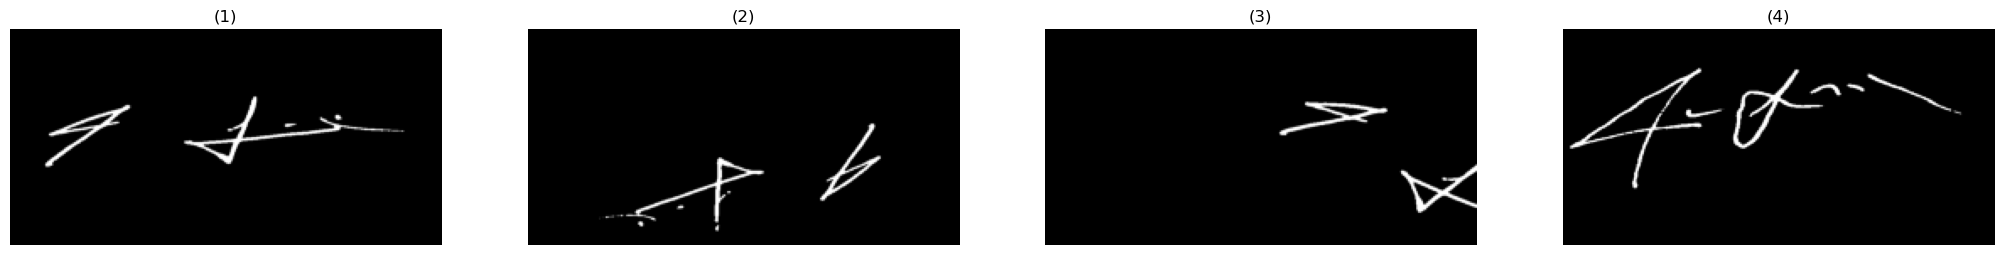

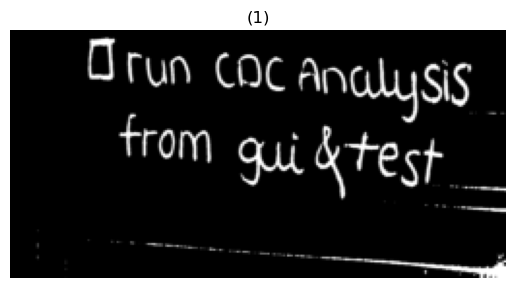

(128, 256, 1)


In [ ]:
def skewCorrection(imgs: np.ndarray) -> None:
    skew_corrected_imgs=[]
    for i in range(len(imgs)):
        skew_corrected_imgs.append(transform.resize(imgs[i], (128, 256), mode='reflect', anti_aliasing=True))
    return skew_corrected_imgs

skew_corrected_real_imgs = skewCorrection(real_imgs_binarized)
skew_corrected_forged_imgs = skewCorrection(forged_imgs_binarized)
skew_corrected_test_imgs = skewCorrection(test_imgs_binarized)

show_images(skew_corrected_real_imgs[:4])
show_images(skew_corrected_forged_imgs[:4])
show_images(skew_corrected_test_imgs)
print(skew_corrected_real_imgs[0].shape)

## size normalization

## thinning/skelatanization

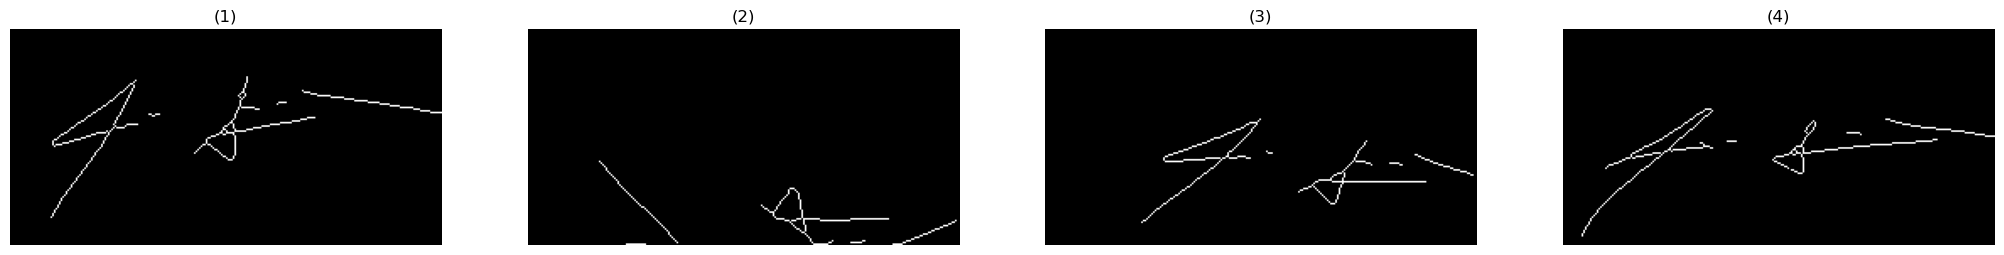

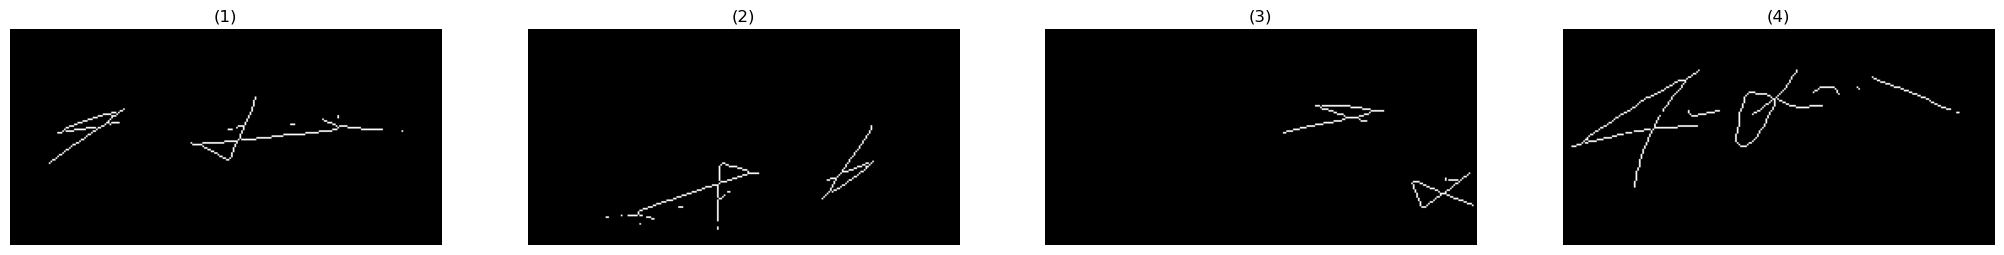

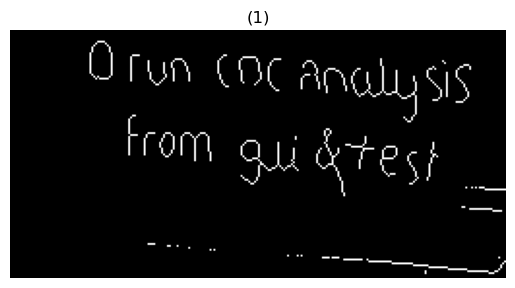

In [ ]:
def skeletonization(imgs: list[np.ndarray]) -> list[np.ndarray]:
     skeletonized_imgs = []
     for i in range(len(imgs)):
        skeletonized_imgs.append(skeletonize(imgs[i]))
     return skeletonized_imgs

real_imgs_skeletonized = skeletonization(skew_corrected_real_imgs)
forged_imgs_skeletonized = skeletonization(skew_corrected_forged_imgs)
test_imgs_skeletonized = skeletonization(skew_corrected_test_imgs)
show_images(real_imgs_skeletonized[:4])
show_images(forged_imgs_skeletonized[:4])
show_images(test_imgs_skeletonized)

## feature extraction

In [ ]:
def HOGFeatureExtractionSkimage(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.uint8)
    features = hog(image, orientations=9, pixels_per_cell=(9, 9),
               cells_per_block=(3,3), transform_sqrt=True, block_norm="L1",
               channel_axis=-1)

    return features

def extractFeatures(imgs: list[np.ndarray]) -> list[np.ndarray]:
    extracted_features = []
    for i in range(len(imgs)):
        extracted_features.append(HOGFeatureExtractionSkimage(imgs[i]))
    return extracted_features




real_extracted_features = extractFeatures(real_imgs_skeletonized)
forged_extracted_features = extractFeatures(forged_imgs_skeletonized)
test_extraced_features = extractFeatures(test_imgs_skeletonized)
test_imgs_label = 0

## SVM using hog

In [ ]:
HOG_features = forged_extracted_features + real_extracted_features
HOG_labels_forged = [0 for _ in range(len(forged_extracted_features))]
HOG_labels_real = [1 for _ in range(len(real_extracted_features))]
HOG_labels = HOG_labels_forged + HOG_labels_real

x_train, x_test, y_train, y_test = train_test_split(HOG_features, HOG_labels, test_size = 0.2, random_state = 42)
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

# Test the model on images it hasn't seen before
accuracy = model.score(x_test, y_test)
#accuracy = model.score(x_train, y_train)
print(x_test[0].shape)
print("SVM using HOG as feature descriptor.", 'accuracy:', accuracy * 100, '%')

(25272,)
SVM using HOG as feature descriptor. accuracy: 62.06896551724138 %


## predicting on test image

In [ ]:
test_prediction = model.predict(test_extraced_features)
print(test_prediction)
if test_prediction == test_imgs_label:
    print("correct prediction")
else:
    print("false prediction")

[0]
correct prediction


## KNN

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(x_train,y_train)
accuracy_KNN = KNN.score(x_test, y_test)
#accuracy_KNN = KNN.score(x_train,y_train)
print("KNN using HOG as feature descriptor.", 'accuracy:', accuracy_KNN * 100, '%')

KNN using HOG as feature descriptor. accuracy: 65.51724137931035 %


## prediction using KNN model


In [ ]:
test_prediction_KNN = KNN.predict(test_extraced_features)
print(test_prediction_KNN)
print(test_imgs_label)
if test_prediction_KNN == test_imgs_label:
    print("correct prediction")
else:
    print("false prediction")

[0]
0
correct prediction
